<a href="https://colab.research.google.com/github/liuxx479/pzCOSMOS/blob/main/prep_kappaTNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from pylab import *
import os
from scipy.interpolate import interp1d
from scipy.integrate import quad
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/My Drive/pzCOSMOS/'

(419311,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


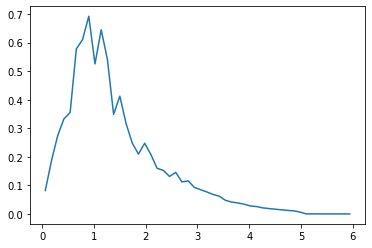

In [27]:
# pz=np.load(root+'pz.npy')
# zs=np.load(root+'z_sources.npy')

# pz=np.load(root+'hist_n_z.npy')
# zs=np.load(root+'hist_z.npy')

fullz=np.load(root+'redshift_catalog.npy')
print (fullz.shape)

zs_edges = np.linspace(0, 6, 51)
zs_full = zs_edges[:-1]+0.5*(zs_edges[1]-zs_edges[0])
pz_full, zs_edges = histogram(fullz, bins=zs_edges, normed=True)

plot(zs_full, pz_full)

In [17]:
# zs_full = np.linspace(0, 5, 101)
# pz_full = interp1d(zs, pz, fill_value="extrapolate")(zs_full)
# pz_full[pz_full<0]=0
# dndz_interp = interp1d(zs_full, pz_full)

# plot(zs,pz,label='from Benjamin')
# plot(zs_full, pz_full,'--',label='extrapolated')
# xlabel('z_s')
# ylabel('p(z)')
# legend()
# title('extrapolte pz from benjamin file, just for test')
# show()

In [36]:

######## planck parameters

# LCDM parameters
A_s = 2.142e-9
h=0.6774
OmegaB = 0.0486
OmegaM = 0.3089
n_s = 0.9667

### derived parameters
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100

OmegaV = 1.0-OmegaM
c = 299792.458 #km/s
H_inv = lambda z: 1.0/(H0*sqrt(OmegaM*(1+z)**3+OmegaV))
DC = lambda z: c*quad(H_inv, 0, z)[0] # comoving distance Mpc
dndz_interp = interp1d(zs_full, pz_full, fill_value="extrapolate")

def lensing_kernel(zs, pz, z_arr=zs_full):
  dndz_interp = interp1d(zs, pz, fill_value="extrapolate")
  integrand = lambda zs, z: dndz_interp(zs)*(1-DC(z)/DC(zs))
  W_wl_fcn = lambda z: 1.5*OmegaM*H0**2*(1+z)*H_inv(z)*DC(z)/c*quad(integrand, z, 5, args=(z,))[0]
  W_wl = array([W_wl_fcn(z) for z in z_arr])
  # W_wl = map(W_wl_fcn, z_arr)
  return W_wl

In [29]:
W_original = lensing_kernel(zs_full, pz_full)
# print (W_original)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


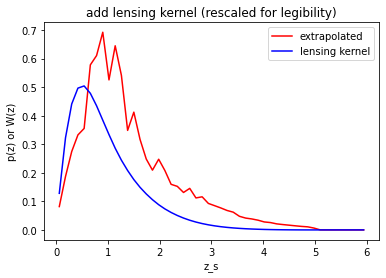

In [43]:
# plot(zs,pz,label='from Benjamin')
plot(zs_full, dndz_interp (zs_full),'r-',label='extrapolated')
# plot(zs_full, pz_mod,'-',label='modified')
plot(zs_full, W_original*5,'b-',label='lensing kernel')
xlabel('z_s')
ylabel('p(z) or W(z)')
legend()
title('add lensing kernel (rescaled for legibility)')
show()

In [33]:
zs_full

array([0.06, 0.18, 0.3 , 0.42, 0.54, 0.66, 0.78, 0.9 , 1.02, 1.14, 1.26,
       1.38, 1.5 , 1.62, 1.74, 1.86, 1.98, 2.1 , 2.22, 2.34, 2.46, 2.58,
       2.7 , 2.82, 2.94, 3.06, 3.18, 3.3 , 3.42, 3.54, 3.66, 3.78, 3.9 ,
       4.02, 4.14, 4.26, 4.38, 4.5 , 4.62, 4.74, 4.86, 4.98, 5.1 , 5.22,
       5.34, 5.46, 5.58, 5.7 , 5.82, 5.94])

In [37]:
######## next, I modify the pz, such that all z>2.6 galaxies are placed at z=2.6
idx=int(where(zs_full==2.58)[0])
pz_mod = pz_full.copy()
pz_mod[idx] = sum(pz_full[idx+1:])
pz_mod[idx+1:]=0
W_mod = lensing_kernel(zs_full, pz_mod)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


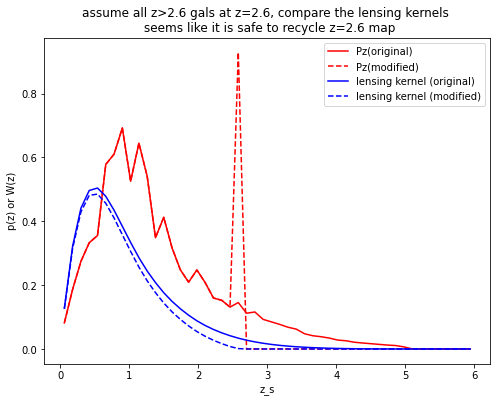

In [44]:
figure(figsize=(8,6))
plot(zs_full, dndz_interp (zs_full),'r-',label='Pz(original)')
plot(zs_full, pz_mod,'r--',label='Pz(modified)')
plot(zs_full, W_original*5,'b-',label='lensing kernel (original)')
plot(zs_full, W_mod*5,'b--',label='lensing kernel (modified)')
xlabel('z_s')
ylabel('p(z) or W(z)')
legend()
title('assume all z>2.6 gals at z=2.6, compare the lensing kernels \n seems like it is safe to recycle z=2.6 map')
show()

In [ ]:
######### to do, down weight z=2.6 bin until the curves match well